In [1]:
### needed if running in docker
# import sys
# sys.path.append("../")

In [2]:
import json 
from master_thesis import utils
from master_thesis.models.lrp_2ench_sd import LRP2ESD
import logging
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
from master_thesis.blockchain_proof_of_work_flp.bpw_lrp_sd_2e import BlockchainLRPSD2E, BPWLRPSD2ESettings

In [3]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

In [45]:
number_of_facilities =3
number_of_customers = 8
number_of_landfills =2
number_of_vehicles =2
vehicle_capacity =4
number_of_scenarios = 40
customer_demand = np.random.rand(number_of_customers,number_of_scenarios)
alpha = 0.8
probabilities = [1/number_of_scenarios] * number_of_scenarios
fix_costs_vehicles = 0.5
fix_costs_facilities = np.random.rand(number_of_facilities)
fix_costs_landfills =  np.random.rand(number_of_landfills)

distance_matrix, coordinates =  utils.get_random_distance_matrix_coordinates(number_of_facilities+number_of_customers + number_of_landfills)

input_data_lrpsd2e = {
    "number_of_facilities": number_of_facilities,
    "number_of_customers": number_of_customers,
    "number_of_landfills": number_of_landfills,
    "distance_matrix": distance_matrix.values.tolist(),
    "vehicle_capacity": vehicle_capacity,
    "customer_demand": customer_demand.tolist(),
    "number_of_scenarios": number_of_scenarios,
    "alpha": alpha,
    "probabilities": probabilities,
    "fix_costs_vehicles": fix_costs_vehicles,    
    "number_of_vehicles":number_of_vehicles,
    "fix_costs_facilities":fix_costs_facilities.tolist(),
    "fix_costs_landfills":fix_costs_landfills.tolist(),
}

In [46]:
model = LRP2ESD(json.dumps(input_data_lrpsd2e))

In [47]:
model.model.max_seconds = 60
model.compute()
if model.model.num_solutions:
    print(f'Total costs: {model.model.objective_value}')
else:
    print('unfeasible')

Total costs: 4.63140230693134


In [48]:
settings_bch = BPWLRPSD2ESettings(max_iter = 10000,
                              max_iter_mining = 1000,
                              early_stopping_num_blocks = 10,
                              num_of_transactions_per_block =40,
                              early_stopping_improvement = 0.001,
                              max_invalid_blocks_in_row = 200,
                              num_halvings = 200,
                              halving_coef = 0.8, 
                              multi_node = False,
                              num_of_nodes = 8,
                             )
blockchain = BlockchainLRPSD2E(json.dumps(input_data_lrpsd2e), settings_bch)

In [49]:
blockchain.solve()

In [50]:
print(blockchain.chain[-1].new_value)

4.6314023069313395


In [51]:
print(blockchain.chain[-1].new_value/model.model.objective_value)

0.9999999999999998


In [52]:
print(blockchain.chain[-1].new_value-model.model.objective_value)

-8.881784197001252e-16


In [53]:
from itertools import cycle
cycol = cycle('bgrcmk')

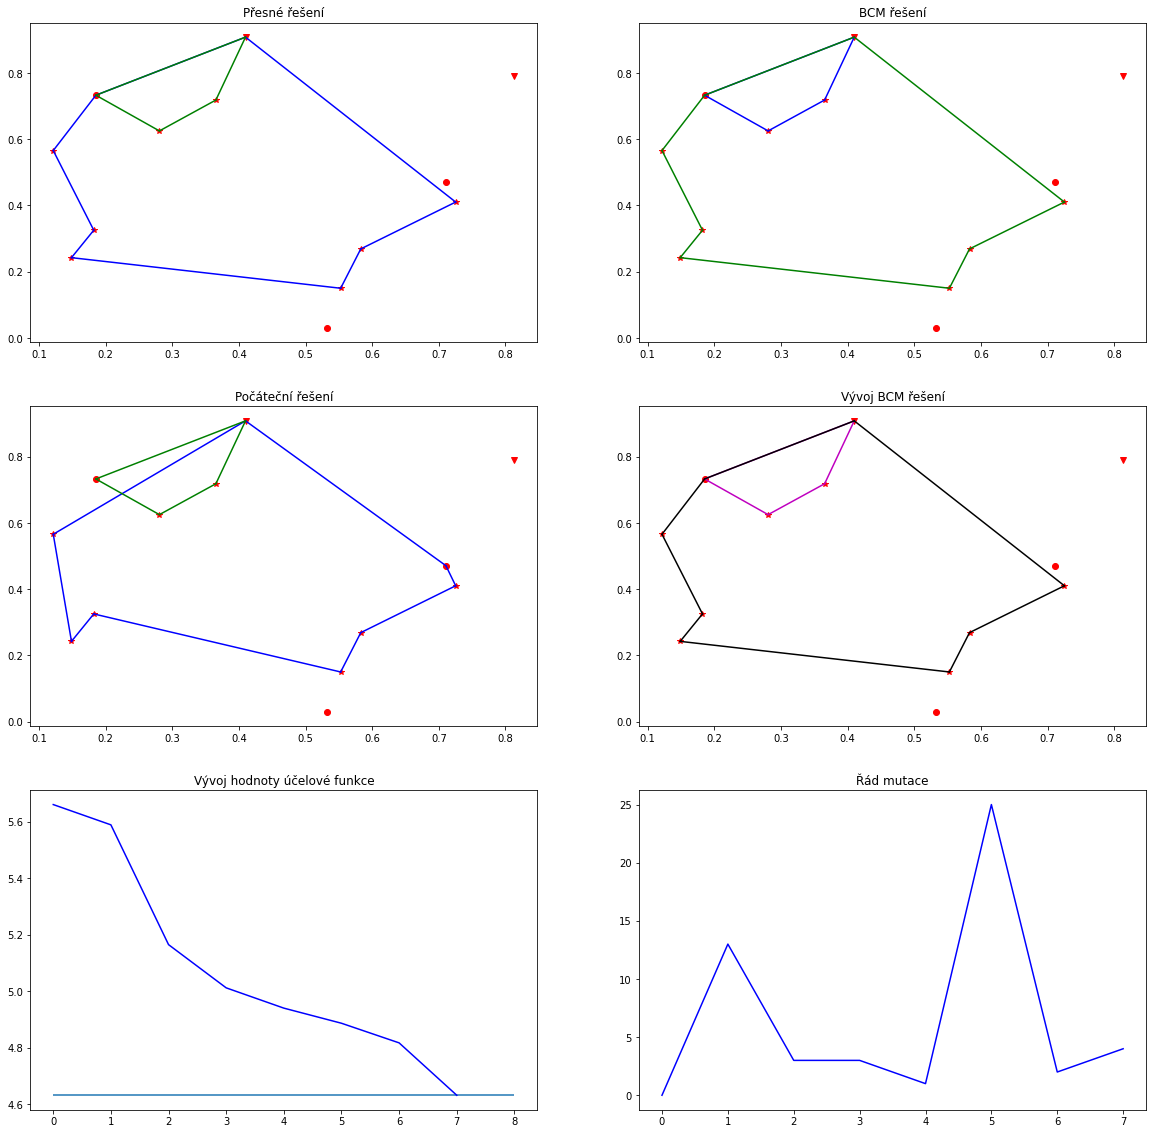

In [54]:
from itertools import product

from itertools import cycle
cycol = cycle('bgrcmk')

colors = [next(cycol) for _ in range(number_of_vehicles)]
optimal_values = [] 
num_of_transactions = []
for ch in range(len(blockchain.chain)):

    fig = plt.figure(figsize = (20,20))
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(322)
    ax3 = fig.add_subplot(323)
    ax4 = fig.add_subplot(324)
    ax5 = fig.add_subplot(325)
    ax6 = fig.add_subplot(326)
    ax1.title.set_text('Přesné řešení')
    ax2.title.set_text('BCM řešení')
    ax3.title.set_text('Počáteční řešení')
    ax4.title.set_text('Vývoj BCM řešení')
    ax5.title.set_text('Vývoj hodnoty účelové funkce')
    ax6.title.set_text('Řád mutace')

    
    for i in range(number_of_facilities):
        ax1.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

    for i in range(number_of_landfills):
        ax1.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


    for i in range(number_of_customers):
        ax1.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

    for k in range(number_of_vehicles):
        color = next(cycol)
        for (i,j) in product(range(number_of_facilities+number_of_landfills +  number_of_customers),range(number_of_facilities+number_of_landfills +  number_of_customers)):
            if model.model.var_by_name(f'route[{i}][{j}][{k}]').x > 0.9:
                ax1.plot([coordinates[i][0],coordinates[j][0]],[coordinates[i][1],coordinates[j][1]],colors[k])

                
                
    for i in range(number_of_facilities):
        ax2.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

    for i in range(number_of_landfills):
        ax2.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


    for i in range(number_of_customers):
        ax2.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

    for index, route in enumerate(blockchain.chain[-1].new_solution.routes):
        color = next(cycol)
        for node in range(len(route)-1):
            ax2.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],colors[index])    

            
            
    for i in range(number_of_facilities):
        ax3.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

    for i in range(number_of_landfills):
        ax3.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


    for i in range(number_of_customers):
        ax3.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

    for index, route in enumerate(blockchain.chain[0].new_solution.routes):
        color = next(cycol)
        for node in range(len(route)-1):
            ax3.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],colors[index])    

            
            

    for i in range(number_of_facilities):
        ax4.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

    for i in range(number_of_landfills):
        ax4.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


    for i in range(number_of_customers):
        ax4.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

    for route in blockchain.chain[ch].new_solution.routes:
        color = next(cycol)
        for node in range(len(route)-1):
            ax4.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],color)           
    
    
    optimal_values.append(blockchain.chain[ch].new_value)
    ax5.hlines(model.model.objective_value, 0,len(blockchain.chain))
    ax5.plot(optimal_values,'b')
    
    num_of_transactions.append(len(blockchain.chain[ch].transaction_combo))
    ax6.plot(num_of_transactions,'b')
    
    display.display(fig)
    display.clear_output(wait=True)
    plt.close()
#     time.sleep(1)

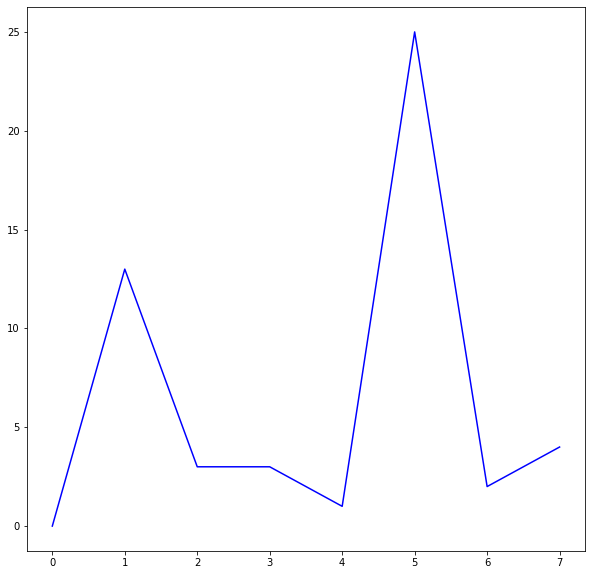

In [62]:
from itertools import product
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from itertools import cycle
cycol = cycle('bgrcmk')

colors = [next(cycol) for _ in range(number_of_vehicles)]
optimal_values = [] 
num_of_transactions = []
for ch in range(len(blockchain.chain)):

    fig = plt.figure(figsize = (10,10))
#     ax4 = fig.add_subplot(111)
#     ax2 = fig.add_subplot(222)
#     ax3 = fig.add_subplot(111)
    ax5 = fig.add_subplot(111)
#        ax1.title.set_text('Přesné řešení')
#     ax2.title.set_text('BCM řešení')
#     ax3.title.set_text('Počáteční řešení')
#     ax4.title.set_text('Vývoj hodnoty účelové funkce')
# #     ax5.title.set_text('Vývoj hodnoty účelové funkce')
#     ax6.title.set_text('Řád mutace')


    legend_elements = [Line2D([0], [0], marker='o',  label='Centrum',
                              color='w',markerfacecolor='r', markersize=10),
                       Line2D([0], [0], marker='v',  label='Skládka',
                              color='w',markerfacecolor='r', markersize=10),
                       Line2D([0], [0], marker='*',  label='Zákazník',
                              color='w',markerfacecolor='r', markersize=10)]
#     for i in range(number_of_facilities):
#         ax1.plot(coordinates[i][0],coordinates[i][1], 'ro', label = 'Centrum' ) 

#     for i in range(number_of_landfills):
#         ax1.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv', label = 'Skládka' ) 


#     for i in range(number_of_customers):
#         ax1.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*', label = 'Zákazník' ) 

#     for k in range(number_of_vehicles):
#         color = next(cycol)
#         for (i,j) in product(range(number_of_facilities+number_of_landfills +  number_of_customers),range(number_of_facilities+number_of_landfills +  number_of_customers)):
#             if model.model.var_by_name(f'route[{i}][{j}][{k}]').x > 0.9:
#                 ax1.plot([coordinates[i][0],coordinates[j][0]],[coordinates[i][1],coordinates[j][1]],colors[k])
    legend_1 = ax1.legend(handles=legend_elements, loc='lower right', shadow=True, fontsize='x-large') 
    legend_1 = ax2.legend(handles=legend_elements, loc='lower right', shadow=True, fontsize='x-large')
    legend_1 = ax3.legend(handles=legend_elements, loc='lower right', shadow=True, fontsize='x-large')  
#     legend_1 = ax4.legend(handles=legend_elements, loc='lower right', shadow=True, fontsize='x-large')
                
#     for i in range(number_of_facilities):
#         ax2.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

#     for i in range(number_of_landfills):
#         ax2.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


#     for i in range(number_of_customers):
#         ax2.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

#     for index, route in enumerate(blockchain.chain[-1].new_solution.routes):
#         color = next(cycol)
#         for node in range(len(route)-1):
#             ax2.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],colors[index])    

            
            
#     for i in range(number_of_facilities):
#         ax3.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

#     for i in range(number_of_landfills):
#         ax3.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


#     for i in range(number_of_customers):
#         ax3.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

#     for index, route in enumerate(blockchain.chain[0].new_solution.routes):
#         color = next(cycol)
#         for node in range(len(route)-1):
#             ax3.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],colors[index])    

            
            

#     for i in range(number_of_facilities):
#         ax4.plot(coordinates[i][0],coordinates[i][1], 'ro' ) 

#     for i in range(number_of_landfills):
#         ax4.plot(coordinates[i+number_of_facilities][0],coordinates[i+number_of_facilities][1], 'rv' ) 


#     for i in range(number_of_customers):
#         ax4.plot(coordinates[i+number_of_facilities+number_of_landfills][0],coordinates[i+number_of_facilities+number_of_landfills][1], 'r*' ) 

#     for route in blockchain.chain[ch].new_solution.routes:
#         color = next(cycol)
#         for node in range(len(route)-1):
#             ax4.plot([coordinates[route[node]][0],coordinates[route[node+1]][0]],[coordinates[route[node]][1],coordinates[route[node+1]][1]],color)           
    
    
#     optimal_values.append(blockchain.chain[ch].new_value)
#     ax4.hlines(model.model.objective_value, 0,len(blockchain.chain)-1,label='Optimální hodnota přesného řešení')
#     ax4.plot(optimal_values,'b',label='Optimální hodnota během výpočtu')
#     legend_4 = ax4.legend(loc='upper right', shadow=True, fontsize='x-large')    
    num_of_transactions.append(len(blockchain.chain[ch].transaction_combo))
    ax5.plot(num_of_transactions,'b')
    
    display.display(fig)
    display.clear_output(wait=True)
    plt.close()
#     time.sleep(1)
fig.savefig('mutace_kombo.pdf')

In [97]:
fig.savefig('prubeh.pdf')

In [ ]:
import time

scenarios = []
# scenarios.append({'facilities':1,
#                   'landfills':1,
#                   'customers':4,
#                   'vehicles':1,
#                   'capacity':4,
#                   'num_scenarios':40,
#                   'max_iter_block': 200,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 50,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 200,
#                  'halving_coef': 0.8})
# scenarios.append({'facilities':1,
#                   'landfills':1,
#                   'customers':5,
#                   'vehicles':1,
#                   'capacity':5,
#                   'num_scenarios':40,
#                   'max_iter_block': 200,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 50,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 200,
#                  'halving_coef': 0.8})
# scenarios.append({'facilities':1,
#                   'landfills':1,
#                   'customers':5,
#                   'vehicles':2,
#                   'capacity':2,
#                   'num_scenarios':40,
#                   'max_iter_block': 400,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 50,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 200,
#                  'halving_coef': 0.8})
# scenarios.append({'facilities':2,
#                   'landfills':2,
#                   'customers':5,
#                   'vehicles':1,
#                   'capacity':5,
#                   'num_scenarios':40,
#                   'max_iter_block': 400,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 50,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 200,
#                  'halving_coef': 0.8})
# scenarios.append({'facilities':3,
#                   'landfills':2,
#                   'customers':6,
#                   'vehicles':2,
#                   'capacity':3,
#                   'num_scenarios':40,
#                   'max_iter_block': 800,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 100,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 100,
#                  'halving_coef': 0.8})
# scenarios.append({'facilities':3,
#                   'landfills':2,
#                   'customers':7,
#                   'vehicles':2,
#                   'capacity':3,
#                   'num_scenarios':40,
#                   'max_iter_block': 800,
#                   'max_iter': 10000,
#                  'max_invalid_blocks': 100,
#                  'transactions': 40,
#                  'multi_workes': False,
#                  'halving_num': 100,
#                  'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':2,
                  'customers':8,
                  'vehicles':3,
                  'capacity':3,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 200,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':3,
                  'customers':9,
                  'vehicles':2,
                  'capacity':4,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 200,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':3,
                  'customers':10,
                  'vehicles':2,
                  'capacity':5,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 200,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':3,
                  'customers':12,
                  'vehicles':2,
                  'capacity':6,
                  'num_scenarios':40,
                  'max_iter_block': 1000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':3,
                  'customers':14,
                  'vehicles':2,
                  'capacity':7,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':3,
                  'landfills':3,
                  'customers':16,
                  'vehicles':3,
                  'capacity':7,
                  'num_scenarios':40,
                  'max_iter_block': 4000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 100,
                 'multi_workes': True,
                 'halving_num': 100,
                 'halving_coef': 0.8})
scenarios.append({'facilities':4,
                  'landfills':3,
                  'customers':20,
                  'vehicles':3,
                  'capacity':7,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 60,
                 'multi_workes': True,
                 'halving_num': 100,
                 'halving_coef': 0.8})
scenarios.append({'facilities':4,
                  'landfills':3,
                  'customers':30,
                  'vehicles':4,
                  'capacity':7,
                  'num_scenarios':40,
                  'max_iter_block': 2000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 60,
                 'multi_workes': True,
                 'halving_num': 100,
                 'halving_coef': 0.8})
scenarios.append({'facilities':4,
                  'landfills':3,
                  'customers':40,
                  'vehicles':4,
                  'capacity':10,
                  'num_scenarios':40,
                  'max_iter_block': 3000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 300,
                 'transactions': 100,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':5,
                  'landfills':3,
                  'customers':50,
                  'vehicles':4,
                  'capacity':12,
                  'num_scenarios':40,
                  'max_iter_block': 3000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 400,
                 'transactions': 100,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':5,
                  'landfills':3,
                  'customers':70,
                  'vehicles':4,
                  'capacity':20,
                  'num_scenarios':40,
                  'max_iter_block': 4000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 400,
                 'transactions': 80,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':5,
                  'landfills':3,
                  'customers':100,
                  'vehicles':5,
                  'capacity':20,
                  'num_scenarios':40,
                  'max_iter_block': 4000,
                  'max_iter': 10000,
                 'max_invalid_blocks': 400,
                 'transactions': 100,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':5,
                  'landfills':3,
                  'customers':200,
                  'vehicles':6,
                  'capacity':35,
                  'num_scenarios':40,
                  'max_iter_block': 5000,
                  'max_iter': 20000,
                 'max_invalid_blocks': 400,
                 'transactions': 200,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})
scenarios.append({'facilities':5,
                  'landfills':3,
                  'customers':400,
                  'vehicles':8,
                  'capacity':50,
                  'num_scenarios':40,
                  'max_iter_block': 5000,
                  'max_iter': 20000,
                 'max_invalid_blocks': 400,
                 'transactions': 400,
                 'multi_workes': True,
                 'halving_num': 200,
                 'halving_coef': 0.8})

with open(f'scenarios.json', 'w') as file:
    json.dump(scenarios, file)
results = []
for i in range(len(scenarios)):
    res = []
    number_of_facilities =scenarios[i]['facilities']
    number_of_customers = scenarios[i]['customers']
    number_of_landfills =scenarios[i]['landfills']
    number_of_vehicles = scenarios[i]['vehicles']
    vehicle_capacity = scenarios[i]['capacity']
    number_of_scenarios = scenarios[i]['num_scenarios']
    customer_demand = np.random.rand(number_of_customers,number_of_scenarios)
    alpha = 0.8
    probabilities = [1/number_of_scenarios] * number_of_scenarios
    fix_costs_vehicles = 0.5
    fix_costs_facilities = np.random.rand(number_of_facilities)
    fix_costs_landfills =  np.random.rand(number_of_landfills)

    distance_matrix, coordinates =  utils.get_random_distance_matrix_coordinates(number_of_facilities+number_of_customers + number_of_landfills)

    input_data_lrpsd2e = {
        "number_of_facilities": number_of_facilities,
        "number_of_customers": number_of_customers,
        "number_of_landfills": number_of_landfills,
        "distance_matrix": distance_matrix.values.tolist(),
        "vehicle_capacity": vehicle_capacity,
        "customer_demand": customer_demand.tolist(),
        "number_of_scenarios": number_of_scenarios,
        "alpha": alpha,
        "probabilities": probabilities,
        "fix_costs_vehicles": fix_costs_vehicles,    
        "number_of_vehicles":number_of_vehicles,
        "fix_costs_facilities":fix_costs_facilities.tolist(),
        "fix_costs_landfills":fix_costs_landfills.tolist(),
    }
    with open(f'data{i}.json', 'w') as file:
        json.dump(input_data_lrpsd2e, file)
    model = LRP2ESD(json.dumps(input_data_lrpsd2e))
    model.model.max_seconds = 3600
    start = time.time()
    model.compute()
    end = time.time()
    if model.model.num_solutions:
        print(f'Total costs MIP: {model.model.objective_value}')
        res.append(model.model.objective_value)
        res.append(model.model.objective_bound)
        res.append(end-start)
    else:
        print('unfeasible')
        continue
    settings_bch = BPWLRPSD2ESettings(max_iter = scenarios[i]['max_iter'],
                          max_iter_mining = scenarios[i]['max_iter_block'],
                          early_stopping_num_blocks = 20,
                          num_of_transactions_per_block = scenarios[i]['transactions'],
                          early_stopping_improvement = 0.001,
                          max_invalid_blocks_in_row = scenarios[i]['max_invalid_blocks'],
                          num_halvings = scenarios[i]['halving_num'],
                          halving_coef = scenarios[i]['halving_coef'], 
                          multi_node = scenarios[i]['multi_workes'],
                          num_of_nodes = 8,
                             )
    blockchain = BlockchainLRPSD2E(json.dumps(input_data_lrpsd2e), settings_bch)
    start = time.time()
    blockchain.solve()
    end = time.time()
    print(f'Total costs BCh: {blockchain.chain[-1].new_value}')
    res.append(blockchain.chain[-1].new_value)
    res.append(1-blockchain.chain[-1].new_value/model.model.objective_value)
    res.append(end-start)
    res.append(f'{number_of_facilities}/{number_of_landfills}/{number_of_customers}/{number_of_vehicles}/{number_of_scenarios}')
    results.append(res)
    with open(f'results.json', 'w') as file:
        json.dump(results, file)

In [ ]:
results = []
scenarios = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
number_of_facilities =2
number_of_customers = 6
number_of_landfills =2
number_of_vehicles = 2
vehicle_capacity = 3
fix_costs_vehicles = 0.5
fix_costs_facilities = np.random.rand(number_of_facilities)
fix_costs_landfills =  np.random.rand(number_of_landfills)

distance_matrix, coordinates =  utils.get_random_distance_matrix_coordinates(number_of_facilities+number_of_customers + number_of_landfills)

for i in range(len(scenarios)):
    res = []

    number_of_scenarios = scenarios[i]
    customer_demand = np.random.rand(number_of_customers,number_of_scenarios)
    alpha = 0.8
    probabilities = [1/number_of_scenarios] * number_of_scenarios
    
    input_data_lrpsd2e = {
        "number_of_facilities": number_of_facilities,
        "number_of_customers": number_of_customers,
        "number_of_landfills": number_of_landfills,
        "distance_matrix": distance_matrix.values.tolist(),
        "vehicle_capacity": vehicle_capacity,
        "customer_demand": customer_demand.tolist(),
        "number_of_scenarios": number_of_scenarios,
        "alpha": alpha,
        "probabilities": probabilities,
        "fix_costs_vehicles": fix_costs_vehicles,    
        "number_of_vehicles":number_of_vehicles,
        "fix_costs_facilities":fix_costs_facilities.tolist(),
        "fix_costs_landfills":fix_costs_landfills.tolist(),
    }
    with open(f'data_scenarios_{i}.json', 'w') as file:
        json.dump(input_data_lrpsd2e, file)
    model = LRP2ESD(json.dumps(input_data_lrpsd2e))
    model.model.max_seconds = 3600
    start = time.time()
    model.compute()
    end = time.time()
    if model.model.num_solutions:
        print(f'Total costs MIP: {model.model.objective_value}')
        res.append(model.model.objective_value)
        res.append(model.model.objective_bound)
        res.append(end-start)
    else:
        print('unfeasible')
        continue
    settings_bch = BPWLRPSD2ESettings(max_iter = 10000,
                          max_iter_mining = 400,
                          early_stopping_num_blocks = 20,
                          num_of_transactions_per_block = 40,
                          early_stopping_improvement = 0.001,
                          max_invalid_blocks_in_row = 50,
                          num_halvings = 200,
                          halving_coef = 0.8, 
                          multi_node = False,
                          num_of_nodes = 8,
                             )
    blockchain = BlockchainLRPSD2E(json.dumps(input_data_lrpsd2e), settings_bch)
    start = time.time()
    blockchain.solve()
    end = time.time()
    print(f'Total costs BCh: {blockchain.chain[-1].new_value}')
    res.append(blockchain.chain[-1].new_value)
    res.append(1-blockchain.chain[-1].new_value/model.model.objective_value)
    res.append(end-start)
    res.append(f'{number_of_facilities}/{number_of_landfills}/{number_of_customers}/{number_of_vehicles}/{number_of_scenarios}')
    results.append(res)
    with open(f'results_scenarios.json', 'w') as file:
        json.dump(results, file)

In [ ]:
results = []
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
number_of_facilities =2
number_of_customers = 6
number_of_landfills =2
number_of_vehicles = 3
vehicle_capacity = 2.5
fix_costs_vehicles = 0.5
fix_costs_facilities = np.random.rand(number_of_facilities)
fix_costs_landfills =  np.random.rand(number_of_landfills)

distance_matrix, coordinates =  utils.get_random_distance_matrix_coordinates(number_of_facilities+number_of_customers + number_of_landfills)

for i in range(len(alphas)):
    res = []

    number_of_scenarios = 100
    customer_demand = np.random.rand(number_of_customers,number_of_scenarios)
    alpha = alphas[i]
    probabilities = [1/number_of_scenarios] * number_of_scenarios
    
    input_data_lrpsd2e = {
        "number_of_facilities": number_of_facilities,
        "number_of_customers": number_of_customers,
        "number_of_landfills": number_of_landfills,
        "distance_matrix": distance_matrix.values.tolist(),
        "vehicle_capacity": vehicle_capacity,
        "customer_demand": customer_demand.tolist(),
        "number_of_scenarios": number_of_scenarios,
        "alpha": alpha,
        "probabilities": probabilities,
        "fix_costs_vehicles": fix_costs_vehicles,    
        "number_of_vehicles":number_of_vehicles,
        "fix_costs_facilities":fix_costs_facilities.tolist(),
        "fix_costs_landfills":fix_costs_landfills.tolist(),
    }
    with open(f'data_alphas_{i}.json', 'w') as file:
        json.dump(input_data_lrpsd2e, file)
    model = LRP2ESD(json.dumps(input_data_lrpsd2e))
    model.model.max_seconds = 3600
    start = time.time()
    model.compute()
    end = time.time()
    if model.model.num_solutions:
        print(f'Total costs MIP: {model.model.objective_value}')
        res.append(model.model.objective_value)
        res.append(model.model.objective_bound)
        res.append(end-start)
    else:
        print('unfeasible')
        res.append('unfeasible')
        results.append(res)
        continue
    settings_bch = BPWLRPSD2ESettings(max_iter = 10000,
                          max_iter_mining = 400,
                          early_stopping_num_blocks = 20,
                          num_of_transactions_per_block = 40,
                          early_stopping_improvement = 0.001,
                          max_invalid_blocks_in_row = 50,
                          num_halvings = 200,
                          halving_coef = 0.8, 
                          multi_node = False,
                          num_of_nodes = 8,
                             )
    blockchain = BlockchainLRPSD2E(json.dumps(input_data_lrpsd2e), settings_bch)
    start = time.time()
    blockchain.solve()
    end = time.time()
    print(f'Total costs BCh: {blockchain.chain[-1].new_value}')
    res.append(blockchain.chain[-1].new_value)
    res.append(1-blockchain.chain[-1].new_value/model.model.objective_value)
    res.append(end-start)
    res.append(f'{number_of_facilities}/{number_of_landfills}/{number_of_customers}/{number_of_vehicles}/{number_of_scenarios}')
    results.append(res)
    with open(f'results_alphas.json', 'w') as file:
        json.dump(results, file)

In [ ]:
import json
import pandas as pd
with open('/mnt/c/Projekty/privat/master_thesis/notebooks/run_2021_03_24/results.json') as f:
    reasult = json.load(f)

In [ ]:
results_df = pd.DataFrame.from_dict(reasult)
results_df.columns =['best_exact', "lower_bound", "cpu_exact", "best_bcm", "gap", "cpu_bcm"]
results_df= results_df.round(2)
print(results_df)
results_df.plot(y = ['best_exact', 'best_bcm'])

In [ ]:
results_df.plot(y = ['cpu_exact', 'cpu_bcm'])

In [ ]:
results_df.plot(y = ['gap'])